In [11]:
import numpy as np
import pandas as pd
import os,re
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
def read_vote_result(result_path,prefix,np_ratio,idx) :
    vote = np.load(result_path + '%s/%s__vote_np_ratio_%d.npy' % (prefix,prefix,np_ratio))
    df = pd.Series(vote,index=idx)
    idx = df.index.str.contains("ENSG")
    return df[idx]

def read_ensemble_result(result_path,prefix,np_ratio,gene_idx) : 
    """
    Args:
        result_path (str): path of ensemble learning model result
        prefix (str): prefix of ensemble learning model
        np_ratio (int): N/P ratio of ensemble learning model
        gene_idx (list): Gene index of ensemble learning model input

    Returns:
        df[idx]: return metric of model 
        vote[idx] : return vote number without synthetic data
    """    

    vote = np.load(result_path + '%s/%s_vote_np_ratio_%d.npy' % (prefix,prefix,np_ratio))
    precision = np.load(result_path + '%s/%s_precision_np_ratio_%d.npy' % (prefix,prefix,np_ratio),allow_pickle=True)
    overall_p = np.load(result_path + '%s/%s_precision_overall_np_ratio_%d.npy' % (prefix,prefix,np_ratio),allow_pickle=True)
    recall = np.load(result_path + '%s/%s_recall_np_ratio_%d.npy' % (prefix,prefix,np_ratio),allow_pickle=True)
    overall_r = np.load(result_path + '%s/%s_recall_overall_np_ratio_%d.npy' % (prefix,prefix,np_ratio),allow_pickle=True)
    df = pd.DataFrame({'Precision' : precision,'Precision_overall' : overall_p,
                       'Recall' : recall, 'Recall_overall' : overall_r})
    vote = pd.Series(vote,index=gene_idx)
    idx = vote.index.str.contains("ENSG")
    return df,vote[idx]

In [13]:
import datetime
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from joblib import parallel_backend
parallel_backend(backend='threading', n_jobs=12)

def model_performance(result_path,prefix,hallmark,gene_idx,metric) :
    """
    Merge the measurement result for ensemble learning model.

    Args:
        result_path (str): The path of ensemble learning model result.
        prefix (str): The prefix of the ensemble learning model.
        hallmark (list / numpy.ndarray): The hallmark gene list.
        gene_idx (list or list like data format): The gene index of vote result. (The vote result is a 1D numpy array, so gene index for vote number array is necessary.)
        metric (str): Name of measurement.

    Returns:
        _type_: _description_
    """    

    no_syn_idx = gene_idx.str.contains("ENSG")
    metric_median = np.zeros(10)
    metric_std = np.zeros(10)
    overall_metric_median = np.zeros(10)
    overall_metric_std = np.zeros(10)
    auc_array = np.zeros(10) 
    auc_std_array = np.zeros(10)
    for np_idx,np_r in enumerate(np.arange(5,55,5)) :
        start = datetime.datetime.now()
        print("%s Predict hallmark gene by vote number of np ratio %d in %s condition" % (start,np_r,prefix))  
        metric_df,vote_df = read_ensemble_result(result_path,"%s_std_by_gene" % prefix,np_r,gene_idx)
        metric_median[np_idx] = np.median(metric_df[metric].values)
        metric_std[np_idx] = np.std(metric_df[metric].values)
        overall_metric_median[np_idx] = np.median(metric_df[metric+'_overall'].values)
        overall_metric_std[np_idx] = np.std(metric_df[metric+'_overall'].values)
        no_syn_gene = gene_idx[no_syn_idx]
        x = np.array(vote_df[no_syn_gene].values)
        y = np.array([1 if x in hallmark else 0 for x in no_syn_gene])
        
        #x_train,x_test,y_train,y_test = train_test_split(x.reshape(-1, 1),y.reshape(-1, 1),test_size = 0.2,stratify = y)
        svm = SVC(kernel='linear')
        cv_score = cross_val_score(svm,x.reshape(-1,1),y,cv=5,scoring='roc_auc')
        auc_array[np_idx] = np.median(cv_score)
        auc_std_array[np_idx] = cv_score.std()
        end = datetime.datetime.now()
        gap = end - start
        print("%s Predict hallmark gene by vote number of np ratio %d in %s condition completed, executime time : %s" % (end,np_r,prefix,str(gap) + 'seconds')) 
        #fpr, tpr, threshold = roc_curve(y, x, pos_label=1)
        #auc_array[np_idx] = auc(fpr, tpr)
    performance_df = pd.DataFrame({'N/P ratio' : np.arange(5,55,5),
                                metric.capitalize() : metric_median,
                                '%s std' % metric : metric_std,
                                'Overall %s' % metric : overall_metric_median,
                                'Overall %s std' % metric : overall_metric_std,
                                'AUC' : auc_array,
                                'AUC std' : auc_std_array})
    return performance_df

def plot_model_performance(metric_df,prefix,output_path,auc=False,metric='Precision',output_format='pdf') :
    """
    Visualization of merge ensemble model performance created by model_performance function.

    Args:
        metric_df (pd.DataFrame): The merge ensemble learning model measurement result.
        prefix (str): The prefix of ensemble learning model.
        output_path (str): The figure output path
        auc (bool, optional): The metric_df contain auc result or not. Defaults to False.
        metric (str, optional): The name of measurement. Defaults to 'Precision'.
        output_format (str, optional): The figure output format. Defaults to 'pdf'.
    """    

    plt.figure(figsize=(10,5))
    plt.errorbar(np.arange(5,55,5),metric_df[metric.capitalize()],yerr = metric_df['%s std' % metric],marker = '*', label=metric.capitalize(),color = "darksalmon",ms = 10)
    plt.errorbar(np.arange(5,55,5),metric_df['Overall %s' % metric],yerr = metric_df['Overall %s std' % metric], marker = '*',label='Overall ' +metric ,color = "mediumaquamarine",ms = 10)
    if auc :
        plt.errorbar(np.arange(5,55,5),metric_df['AUC'],yerr=metric_df['AUC std'],marker = '*', label='AUC',color = "#FFAACF",ms = 10)
    plt.ylabel("Metrics")
    plt.ylim([0,1])
    plt.xlabel('N/P ratio')
    plt.legend()
    plt.title("Ensemble learning model performance (%s)" % (prefix))
    plt.savefig(output_path + 'ensemble_performance_predict_by_vote_%s_%s.%s' % (metric,prefix,output_format),bbox_inches = 'tight',dpi=300,format=output_format)

2023-12-25 15:03:53.643526 Predict hallmark gene by vote number of np ratio 5 in hbv_only condition
2023-12-25 15:04:02.619744 Predict hallmark gene by vote number of np ratio 5 in hbv_only condition completed, executime time : 0:00:08.976218seconds
2023-12-25 15:04:02.619923 Predict hallmark gene by vote number of np ratio 10 in hbv_only condition
2023-12-25 15:04:40.832670 Predict hallmark gene by vote number of np ratio 10 in hbv_only condition completed, executime time : 0:00:38.212747seconds
2023-12-25 15:04:40.832849 Predict hallmark gene by vote number of np ratio 15 in hbv_only condition
2023-12-25 15:06:01.343642 Predict hallmark gene by vote number of np ratio 15 in hbv_only condition completed, executime time : 0:01:20.510793seconds
2023-12-25 15:06:01.343810 Predict hallmark gene by vote number of np ratio 20 in hbv_only condition
2023-12-25 15:08:06.923124 Predict hallmark gene by vote number of np ratio 20 in hbv_only condition completed, executime time : 0:02:05.579314se

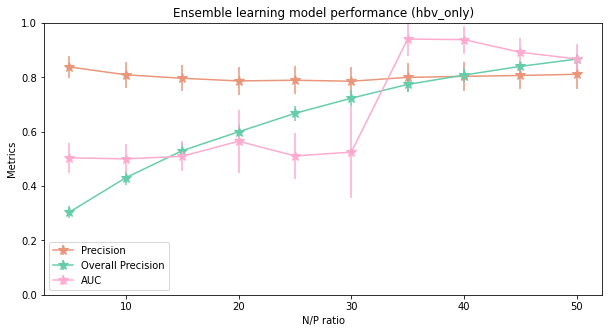

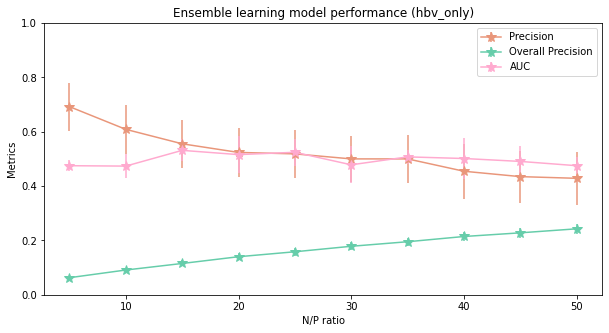

In [16]:
repo_dir = '/home/bruce1996/repo/LIHC_anomaly_detection/'
training_path = repo_dir + 'data/Ensemble-learning-training-data/'
hallmark_df = pd.read_csv(repo_dir + 'data/Hallmark-information/hbv_gene_conversion_table.txt',sep='\t')
hallmark_genes = hallmark_df.loc[np.where(hallmark_df['Coding gene'] == 'Coding gene',True,False),'Ensembl_ID'].values
output_path = "/home/bruce1996/repo/LIHC_anomaly_detection/result/ensemble_learning_model_performance/"
##
prefix = 'hbv_only'
metric = 'Precision'
for da in ['with_synthetic','without_synthetic'] :
    vote_path = repo_dir + 'data/Ensemble-leanring-result/%s/' % da
    if da != 'with_synthetic' :
        exp_m = pd.read_csv(training_path + "lihc_coding_gene_std_by_gene_%s.txt" % prefix,sep='\t',index_col=0)
    else :
        exp_m = pd.read_csv(training_path + "lihc_coding_gene_std_by_gene_%s_with_synthetic.txt" % prefix,sep='\t',index_col=0)

    model_performance_df = model_performance(vote_path,prefix,hallmark_genes,exp_m.index,metric)
    model_performance_df.to_csv(output_path + "ensemble_model_performance_%s_%s_with_vote_number_svm.txt" % (da,prefix),sep='\t')
    plot_model_performance(model_performance_df,prefix=prefix,metric=metric,output_path=output_path,auc=True)

In [7]:
def plot_metric(metric_df,prefix,output_path,format='png',metric = 'Precision') :
    
    plt.figure(figsize=(10,5))
    plt.errorbar(np.arange(5,55,5),metric_df[metric],yerr = metric_df[metric+'_std'],marker = '*', label="%s after data augmentation" % metric,color = "darksalmon",ms = 10)
    plt.errorbar(np.arange(5,55,5),metric_df[metric + '_wda'],yerr = metric_df[metric + '_wda_std'], marker = '*',label="%s without data augmentation" % metric ,color = "mediumaquamarine",ms = 10)
    plt.ylabel("Metrics")
    plt.ylim([0,1])
    plt.xlabel('N/P ratio')
    plt.legend()
    plt.savefig(output_path + 'data_augmentation_comparison_%s_%s.%s' % (metric,prefix,format),format=format,bbox_inches = 'tight',dpi=300)
    

Median precision with synthetic data is 0.733, standard error is 0.020
Median precision without synthetic data is 0.392, standard error is 0.089
Median recall with synthetic data is 0.771, standard error is 0.046
Median recall without synthetic data is 0.475, standard error is 0.104


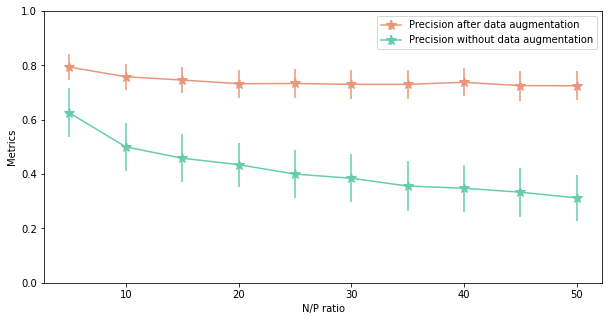

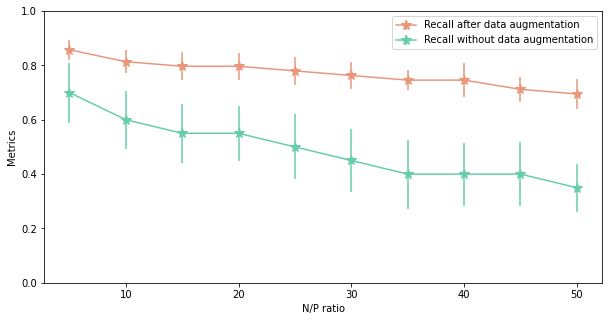

In [10]:
ensemble_path = repo_dir + "data/Ensemble-leanring-result/"
condition = 'hbv_only'

precision_without_da = np.zeros(10)
recall_without_da = np.zeros(10)
precision_da = np.zeros(10)
recall_da = np.zeros(10)

precision_without_da_std = np.zeros(10)
recall_without_da_std = np.zeros(10)
precision_da_std = np.zeros(10)
recall_da_std = np.zeros(10)

for idx,np_ratio in enumerate(range(5,55,5)) :
    da_metric = {'Precision' : np.load(ensemble_path + "with_synthetic/%s/%s_precision_np_ratio_%d.npy" % (condition,condition,np_ratio),allow_pickle=True),
                'Recall' : np.load(ensemble_path + "with_synthetic/%s/%s_recall_np_ratio_%d.npy" % (condition,condition,np_ratio),allow_pickle=True)}
    without_da_metric = {'Precision' : np.load(ensemble_path + "without_synthetic/%s/%s_precision_np_ratio_%d.npy" % (condition,condition,np_ratio),allow_pickle=True),
                'Recall' : np.load(ensemble_path + "without_synthetic/%s/%s_recall_np_ratio_%d.npy" % (condition,condition,np_ratio),allow_pickle=True)}
    precision_without_da[idx] = np.median(without_da_metric['Precision'])
    precision_without_da_std[idx] = np.std(without_da_metric['Precision'])
    precision_da[idx] = np.median(da_metric['Precision'])
    precision_da_std[idx] = np.std(da_metric['Precision'])
    #recall
    recall_without_da[idx] = np.median(without_da_metric['Recall'])
    recall_without_da_std[idx] = np.std(without_da_metric['Recall'])
    recall_da[idx] = np.median(da_metric['Recall'])
    recall_da_std[idx] = np.std(da_metric['Recall'])

metric_df = pd.DataFrame({'Precision' : precision_da,'Precision_std' : precision_da_std,
                          'Precision_wda' : precision_without_da,'Precision_wda_std' : precision_without_da_std,
                          'Recall' : recall_da,'Recall_std' : recall_da_std,
                          'Recall_wda' : recall_without_da,'Recall_wda_std' : recall_without_da_std})

output_path = "/home/bruce1996/repo/LIHC_anomaly_detection/result/ensemble_learning_model_performance/"
plot_metric(metric_df,condition,output_path,format='pdf')
plot_metric(metric_df,condition,output_path,metric='Recall',format='pdf')

print(f'Median precision with synthetic data is %0.3f, standard error is %0.3f' % (np.median(precision_da),np.std(precision_da)))
print(f'Median precision without synthetic data is %0.3f, standard error is %0.3f' % (np.median(precision_without_da),np.std(precision_without_da)))
print(f'Median recall with synthetic data is %0.3f, standard error is %0.3f' % (np.median(recall_da),np.std(recall_da)))
print(f'Median recall without synthetic data is %0.3f, standard error is %0.3f' % (np.median(recall_without_da),np.std(recall_without_da)))